In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from lemmatizer import nltk_tag_to_wordnet_tag,lemmatize_tweet, tweet_cleaner

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/neelagarwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/neelagarwal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/neelagarwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/neelagarwal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/neelagarwal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
# import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize

# from nltk.corpus import stopwords

# import cleantext
# import demoji
# import re

# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('punkt_tab')
# # nltk.download('popular')

In [3]:
# import multiprocessing

# def worker(num):
#     """thread worker function"""
#     print(f'Worker: {num}')

# if __name__ == '__main__':
#     jobs = []
#     for i in range(5):
#         p = multiprocessing.Process(target=worker, args=(i,))
#         jobs.append(p)
#         p.start()

In [4]:
training_data = pd.read_csv("training_data.csv")
training_data

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999
...,...,...,...,...,...,...,...
333982,97,"b""I am working to make Social Security stronge...",ExpandSocialSecurity,29,2018,-0.423522,0.005929
333983,11,b'Climate change -&gt; altered CA forest ecosy...,actonclimate,11,2016,-0.436272,-0.546745
333984,82,b'The @USChamber and other business lobbying g...,climate,34,2019,-0.309244,-0.070852
333985,1,b'I look forward to answering constituent\xe2\...,TeleTownHall,1,2016,-0.516671,0.205851


In [5]:
# def tweet_cleaner(input_text):
#     # input_text = "the quick brown fox    jumps over the lazy dog.."
#     input_text = demoji.replace(input_text,"") # removal of emoji
#     input_text = " ".join(input_text.split()) # removal of extra spaces 
#     input_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', input_text) # removal of url startign with 'http'

#     input_text_list = input_text.split()
#     input_text = cleantext.clean(input_text,
#                                     punct = True, # removal of punctuation
#                                     )
#     stop_words = set(stopwords.words('english'))
#     input_text = " ".join([word for word in input_text.split() if word not in stop_words]) # removal of stopwords
#     input_text = " ".join([word for word in input_text.split() if len(word) >= 3]) # removal of words less than 3 characters
#     return(input_text)

In [6]:
training_df = pd.DataFrame(data=training_data)

In [7]:
    # removal of b's in the beginning 
    def removeB(input_text):
        if (input_text.startswith("b'") or input_text.startswith("b\"")) and input_text.endswith("'"):
            input_text = input_text[2:-1]
            
        if (input_text.startswith("b'") or input_text.startswith("b\"")) and (not(input_text.endswith("'"))):
            input_text = input_text[2:]
        return input_text

In [8]:
x = removeB(training_df.loc[0,"full_text"])
print(x)

WATCH my speech on the @SenateFloor to learn more about the #PatientFreedomAct and what it means for West Virginia. https://t.co/MXV9dHZOTe


In [9]:
training_df["full_text"] = training_df["full_text"].apply(removeB)

In [10]:
training_df

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,8,WATCH my speech on the @SenateFloor to learn m...,PatientFreedomAct,3,2017,0.243962,0.170366
1,2,Boehner delays leadership races. Only speaker ...,rossformajoritywhip,3,2015,0.561728,0.089540
2,5,I'll be sharing #scarynumbers about #governmen...,scarynumbers governmentspending,4,2014,0.513246,-0.224541
3,34,"#OTD in '64, LBJ took important step towards f...",OTD,14,2017,-0.241932,0.097843
4,23,My bipartisan bill is a step toward protecting...,VA07,7,2020,-0.225722,0.329999
...,...,...,...,...,...,...,...
333982,97,I am working to make Social Security stronger ...,ExpandSocialSecurity,29,2018,-0.423522,0.005929
333983,11,Climate change -&gt; altered CA forest ecosyst...,actonclimate,11,2016,-0.436272,-0.546745
333984,82,The @USChamber and other business lobbying gro...,climate,34,2019,-0.309244,-0.070852
333985,1,I look forward to answering constituent\xe2\x8...,TeleTownHall,1,2016,-0.516671,0.205851


In [11]:

# output_text = tweet_cleaner("The quick brown fosx dnfdf jdifwdofef.,.,.,.,,")
# output_text

# for i in range(len(training_df)):
#     training_df.loc[i,"text_clean"] = lemmatize_tweet(training_df.loc[i,"full_text"])

training_df["text_clean"] = training_df["full_text"].apply(lemmatize_tweet)


In [12]:
training_df

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,text_clean
0,8,WATCH my speech on the @SenateFloor to learn m...,PatientFreedomAct,3,2017,0.243962,0.170366,WATCH speech SenateFloor learn PatientFreedomA...
1,2,Boehner delays leadership races. Only speaker ...,rossformajoritywhip,3,2015,0.561728,0.089540,Boehner delay leadership race Only speaker ele...
2,5,I'll be sharing #scarynumbers about #governmen...,scarynumbers governmentspending,4,2014,0.513246,-0.224541,Ill share scarynumbers governmentspending rest...
3,34,"#OTD in '64, LBJ took important step towards f...",OTD,14,2017,-0.241932,0.097843,OTD LBJ take important step towards fulfil pro...
4,23,My bipartisan bill is a step toward protecting...,VA07,7,2020,-0.225722,0.329999,bipartisan bill step toward protect amp expand...
...,...,...,...,...,...,...,...,...
333982,97,I am working to make Social Security stronger ...,ExpandSocialSecurity,29,2018,-0.423522,0.005929,work make Social Security strong generation co...
333983,11,Climate change -&gt; altered CA forest ecosyst...,actonclimate,11,2016,-0.436272,-0.546745,Climate change alter forest ecosystems dangero...
333984,82,The @USChamber and other business lobbying gro...,climate,34,2019,-0.309244,-0.070852,The USChamber business lobby group need become...
333985,1,I look forward to answering constituent\xe2\x8...,TeleTownHall,1,2016,-0.516671,0.205851,look forward answer constituentxe2x80x99s ques...


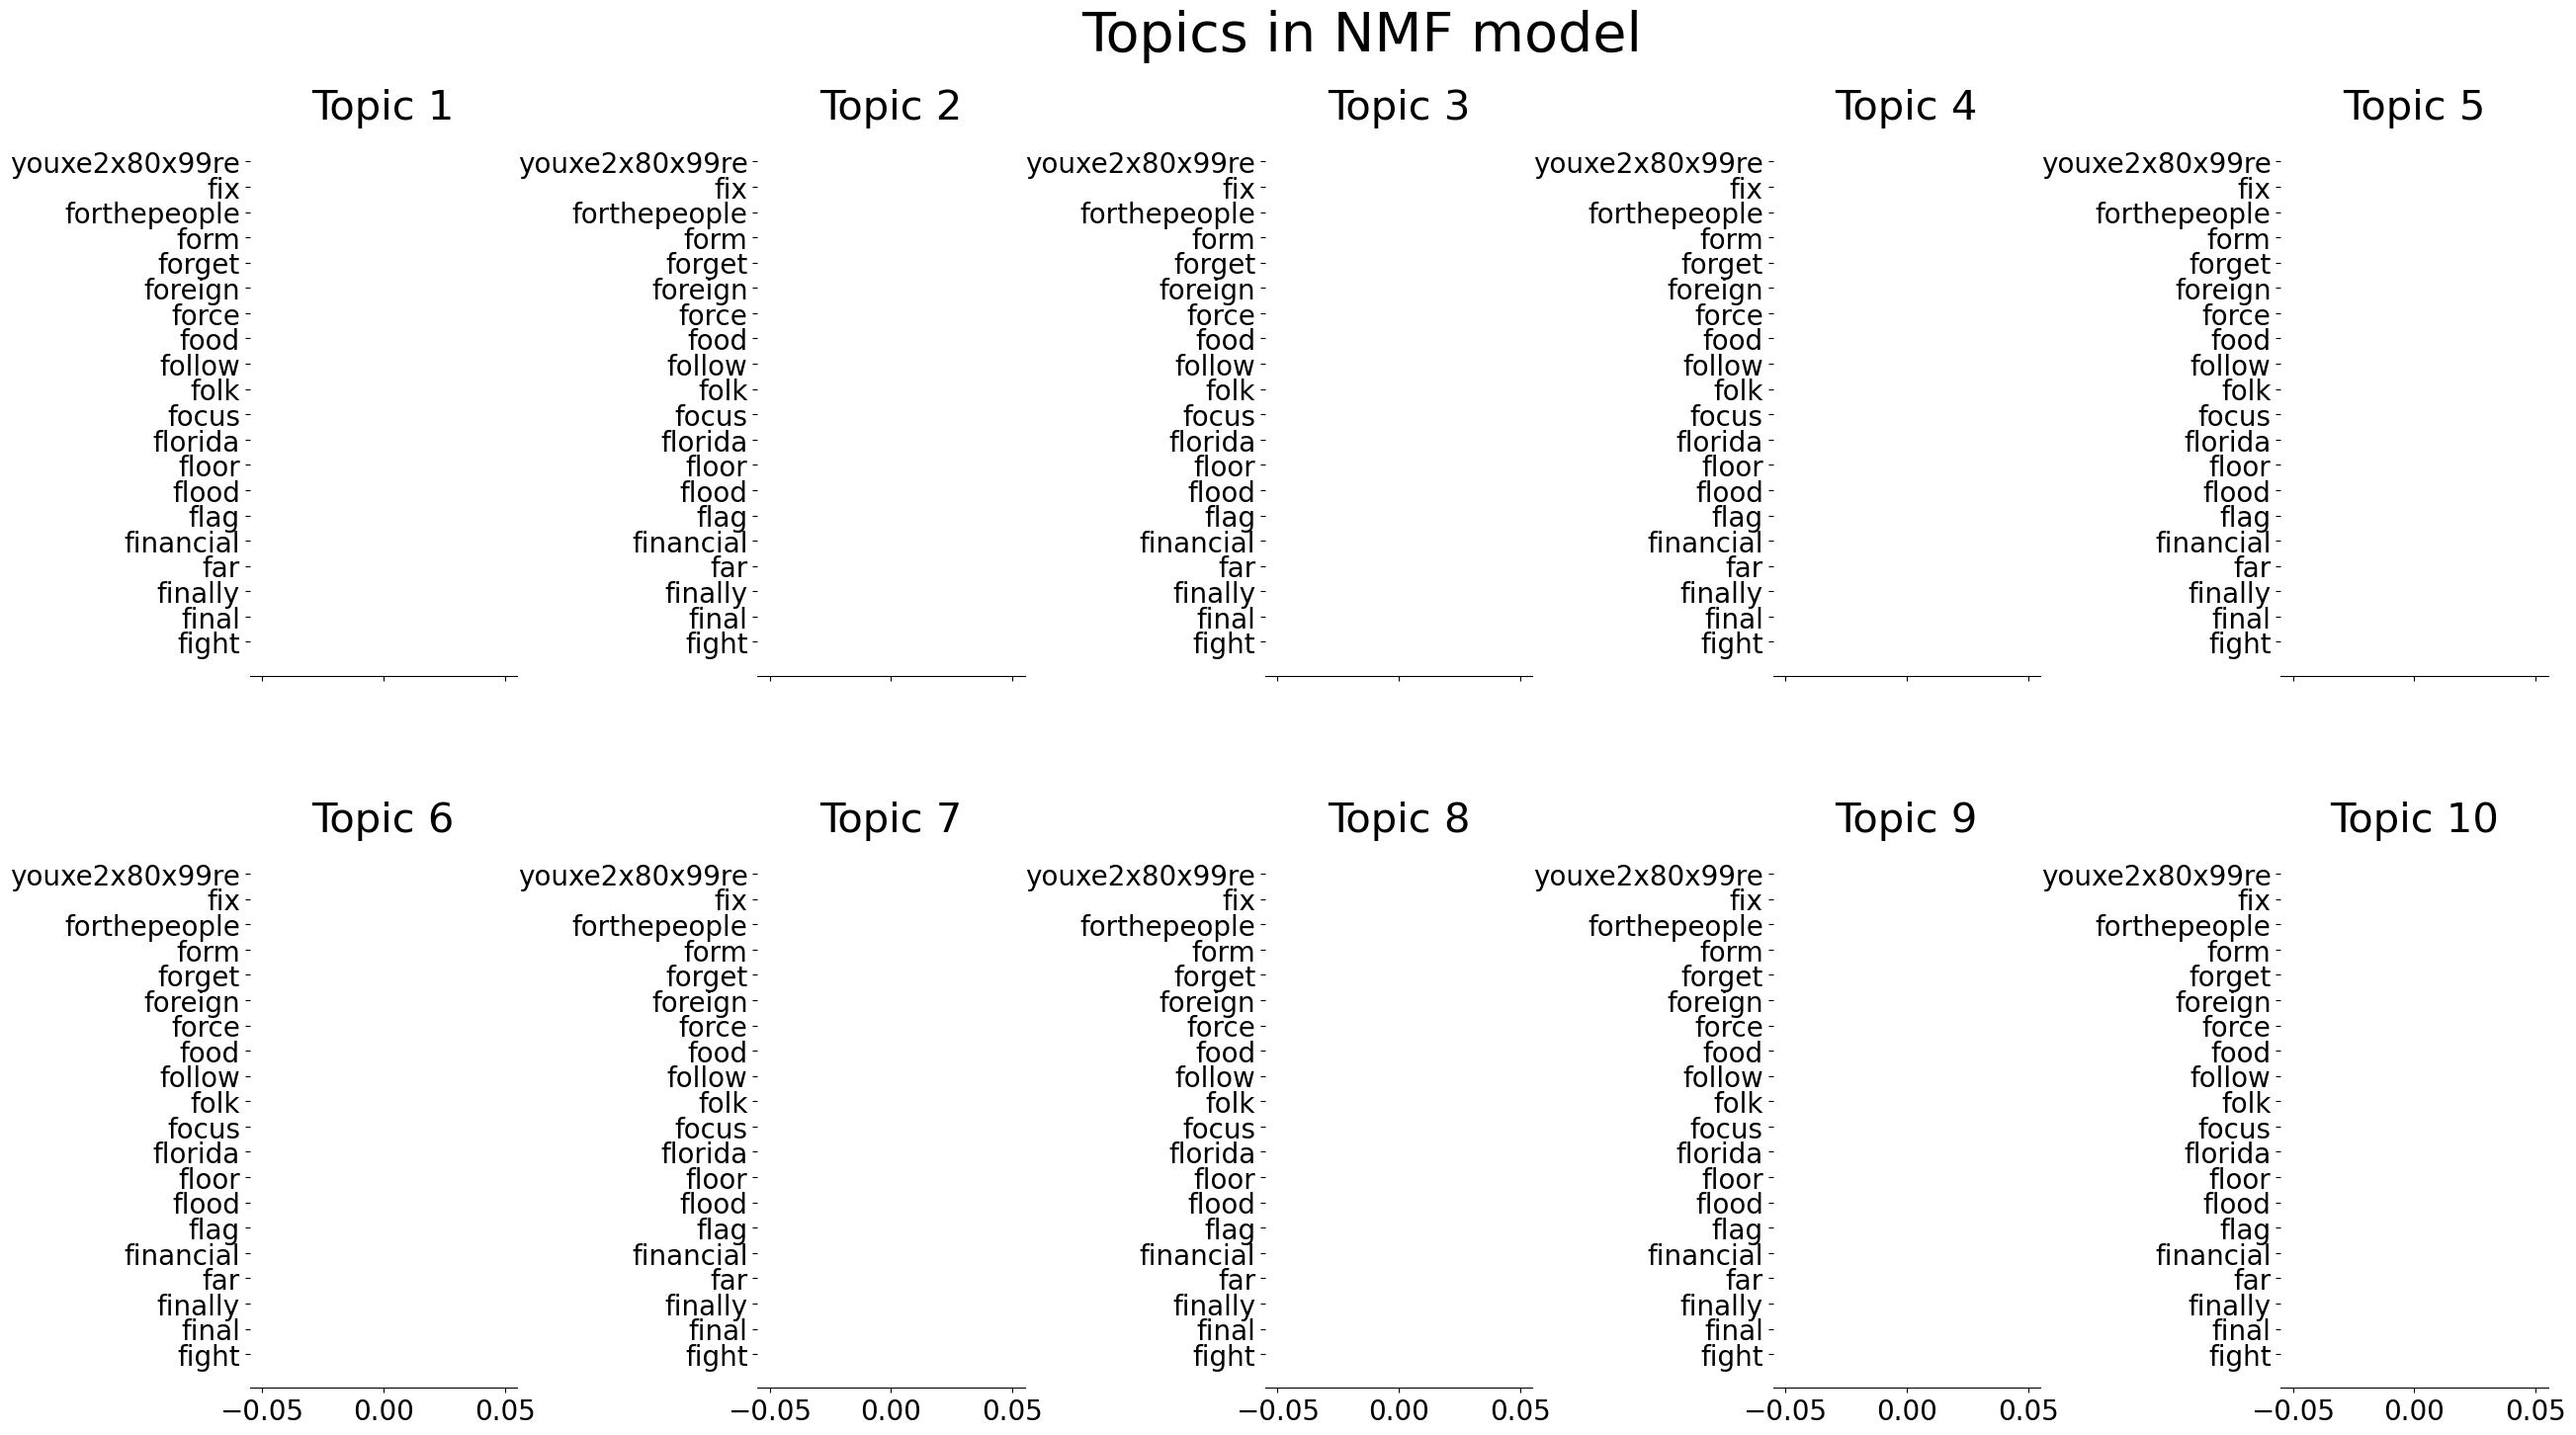

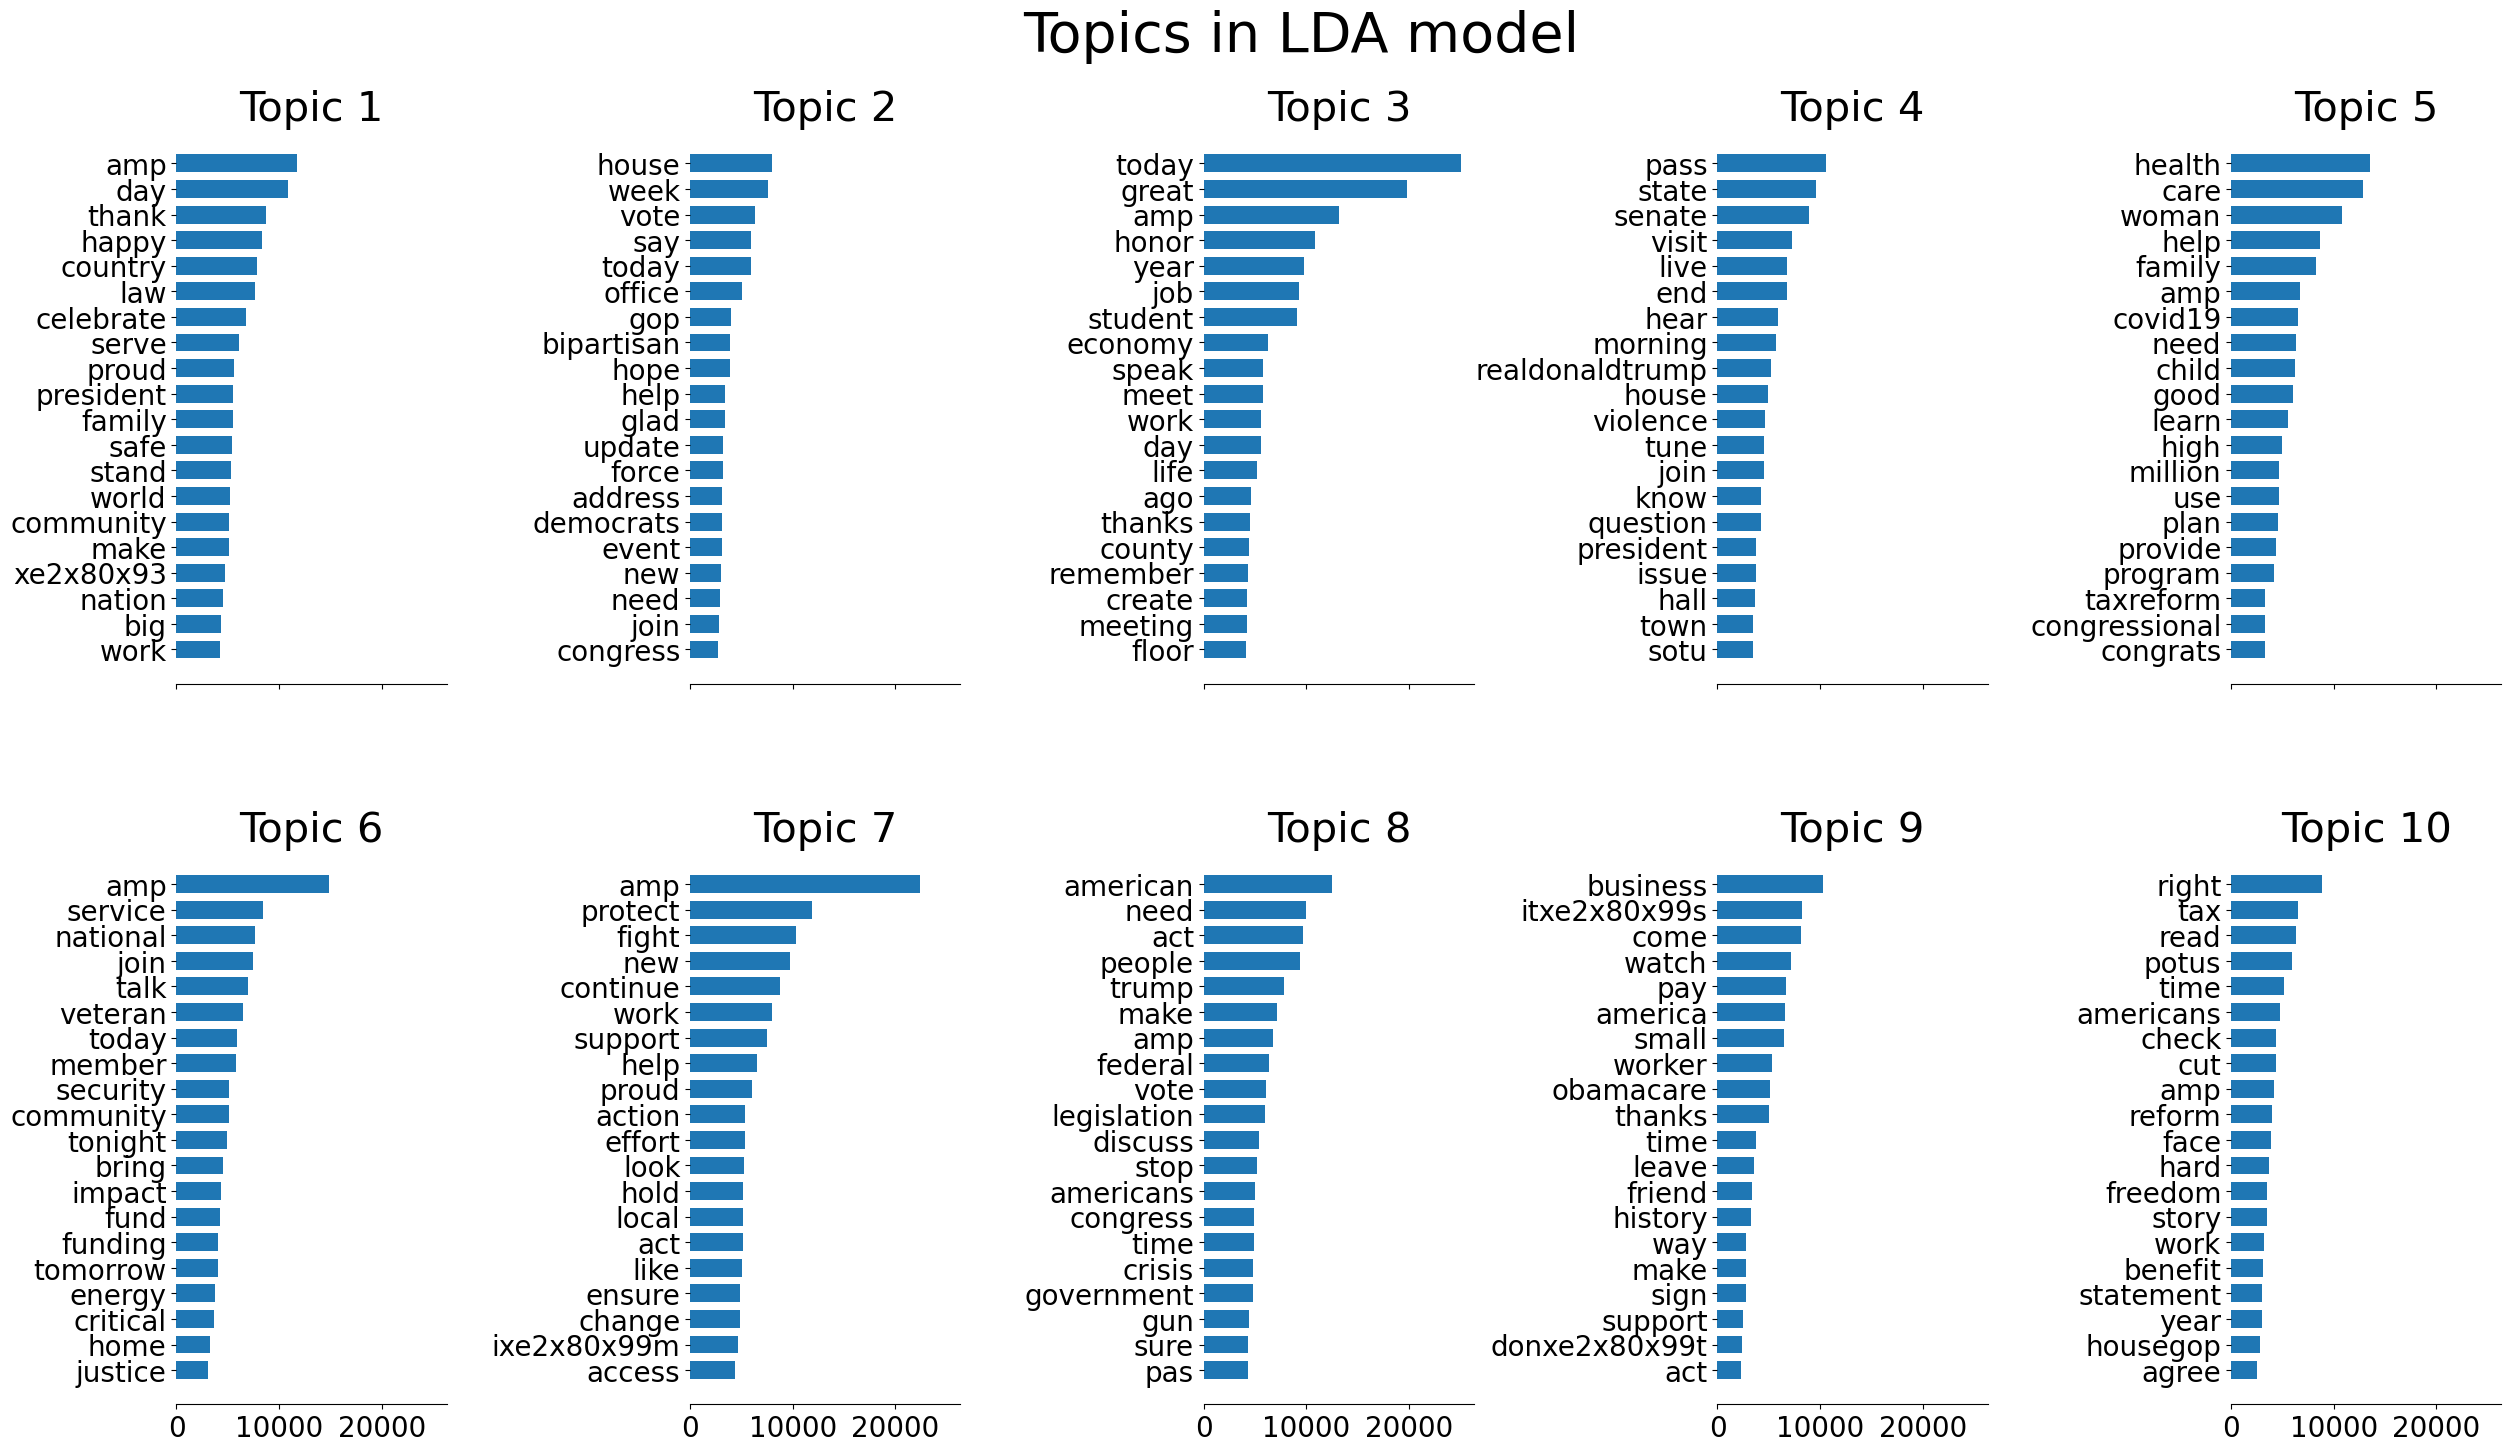

In [13]:
from time import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Assume training_df is your DataFrame and 'text_clean' is the column with cleaned text
data_samples = training_df['text_clean'].values

n_samples = len(data_samples)
n_features = 1000
n_components = 10
n_top_words = 20

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Vectorization: NMF with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Vectorization: LDA with CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

# Fit NMF model
nmf = NMF(n_components=n_components, random_state=1, alpha_W=0.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, 'Topics in NMF model')

# Fit LDA model
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

# Analyzing and comparing the results
# You would need to look at the topics each model produces and assess their relevance and distinctiveness.
